### To do:
Re-scrape data with upvotes / downvotes

Get NFL dataset to compare to

Calculate how many PER points being black is worth in terms of popularity

In [212]:
#import praw
import time
import requests
import difflib
from ast import literal_eval
from datetime import datetime
from fuzzywuzzy import process as fuzzy_process
import  json
import pandas as pd
import numpy as np
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

### Use PRAW and reddit API to get lots of comments

In [2]:
client_id = 'wgPHyF8Ogio_dA'
secret = '3BkmoB6wVUWzF0wsOSkIxnI-guo'
user_agent = 'r/nba race sentiment 0.1 by /u/Umiy'

In [3]:
r = praw.Reddit(user_agent=user_agent, client_id=client_id, client_secret=secret)
r_nba = r.subreddit('nba')

In [138]:
def parse_submission( submission):
    text = submission.title + '. ' + submission.selftext
    creation_date = submission.created
    author = submission.author #.name for PRAW
    flair = submission.author_flair_text
    score = submission.score
    return (text, creation_date, author, flair, score)

In [140]:
def parse_comment( comment):
    if hasattr(comment, 'body') and comment.author != None:
        text = comment.body
        creation_date = comment.created
        author = comment.author
        flair = comment.author_flair_text
        score = comment.score
        return (text, creation_date, author, flair, score)
    return ('', 1, '', '', 0)

In [6]:
def get_month(year, month, month_length):
    ''' Get comments and submissions for one month. takes ~ 1h 15 minutes.
    '''
    data_col = ['text', 'timestamp', 'user', 'flair']
    print('Downloading submssions for {}-{}'.format(year, month))
    month_submissions = [list(r_nba.submissions(datetime(year,month,day).timestamp(), datetime(year,month,day+1).timestamp() )) for day in range(1,month_length)]
    month_submissions = [x for day_submissions in month_submissions for x in day_submissions]
    
    print('Downloaded {} submissions'.format(len(month_submissions)))
    ops = [ parse_submission(submission) for submission in month_submissions]
    submission_df =(pd.DataFrame(ops, columns=data_col)
                      .assign(source = lambda x: 'submission') )
    print('Made dataframe of shape {}'.format(submission_df.shape) )
    
    print('Downloading comments (this could take an hour)')
    comments_list = [submission.comments.list() for submission in month_submissions if hasattr(submission, 'comments')]
    comments = [ parse_comment(comment) for comments in  comments_list for comment in comments]
    print('Downloaded {} comments'.format(len(comments) ) )
    comment_df = (pd.DataFrame(comments, columns=data_col)
                    .assign(source = lambda x: 'comment') )
    return pd.concat([submission_df, comment_df]), ops, comments

In [ ]:
%%time
# this no longer works 
month_df, submissions, comments = get_month(2017, 11, 30)

### Get comments from pushshift:

In [225]:
def parse_submission_pushshift( submission):
    selftext = ''
    if 'selftext' in submission and 'author" in ':
        selftext = submission['selftext']
    text = submission['title'] + '. ' + selftext
    creation_date = submission['created_utc']
    author = submission['author'] #.name for PRAW
    flair = submission['author_flair_text']
    score = submission['score']
    return (text, creation_date, author, flair, score)

In [226]:
def parse_comment_pushshift( comment):
    fields = ['body', 'created_utc', 'author', 'author_flair_text', 'score']
    if all( [field in comment for field in fields]):
        return [comment[x] for x in fields]
    return ('', 1, '', '', -1000)

In [227]:
def get_month_pushshift( year, month, day):
    data_col = ['text', 'timestamp', 'user', 'flair', 'score']
    start_after = datetime.now() - datetime(year,month,1)
    end_before = datetime.now() - datetime(year,month,day)
    start_hour = start_after.days * 24 + start_after.seconds  // 3600
    end_hour = end_before.days * 24 + end_before.seconds  // 3600 - 1 
    
    url_params = {'subreddit': 'nba',
                  'size':500}#,
#                  'fields': ','.join( ['author','author_flair_text','body','created_utc'])}
    submission_url = 'https://api.pushshift.io/reddit/search/submission/'
    month_submissions = []
    
    print('Downloading submssions for {}-{}'.format(year, month))
    hour_step = 6
    for hour in range(start_hour, end_hour, -hour_step):
        url_params.update({'before': str(hour)+'h', 'after': str(hour+hour_step) + 'h'})
        month_submissions.extend(json.loads(requests.get(submission_url, params=url_params).text)['data'])
        time.sleep(0.5)
        
    print('Downloaded {} submissions'.format(len(month_submissions)))
    
    ops = [ parse_submission_pushshift(submission) for submission in month_submissions]
    submission_df =(pd.DataFrame(ops, columns=data_col)
                      .assign(source = lambda x: 'submission') )
    print('Made dataframe of shape {}'.format(submission_df.shape) )
    
    print('Downloading comments')
    comment_url = 'https://api.pushshift.io/reddit/search/comment/'
    comments = []
    hour_step = 1
    for hour in range(start_hour, end_hour, -hour_step):
        url_params.update({'before': str(hour)+'h', 'after': str(hour+hour_step) + 'h'})
        comments.extend(json.loads(requests.get(comment_url, params=url_params).text)['data'])
        time.sleep(0.5)
    comments = [ parse_comment_pushshift(comment) for comment in comments]
    print('Downloaded {} comments'.format(len(comments) ) )
    comment_df = (pd.DataFrame(comments, columns=data_col)
                    .assign(source = lambda x: 'comment') )
       
    return pd.concat([submission_df, comment_df]).drop_duplicates(), ops, comments

In [228]:
%%time
month_df, submissions, comments = get_month_pushshift(2018,4,30)

Downloaded 24985 submissions
Made dataframe of shape (24985, 6)


ConnectionError: ('Connection aborted.', OSError("(10060, 'WSAETIMEDOUT')",))

### Save / load

In [176]:
month_df.to_csv('201711-comments_submissions.tsv.gz',
                  sep = '\t', encoding = 'utf-8', compression = 'gzip', index = False)

In [2]:
nov_df = pd.read_csv('201711-comments_submissions.tsv.gz', sep = '\t', encoding = 'utf-8', compression = 'gzip')
dec_df = pd.read_csv('201712-comments_submissions.tsv.gz', sep = '\t', encoding = 'utf-8', compression = 'gzip')
jan_df = pd.read_csv('201801-comments_submissions.tsv.gz', sep = '\t', encoding = 'utf-8', compression = 'gzip')
feb_df = pd.read_csv('201802-comments_submissions.tsv.gz', sep = '\t', encoding = 'utf-8', compression = 'gzip')
mar_df = pd.read_csv('201803-comments_submissions.tsv.gz', sep = '\t', encoding = 'utf-8', compression = 'gzip')

C:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
combo_df = pd.concat([dec_df, jan_df, feb_df, mar_df]).dropna(subset=['text'])
print(combo_df.shape)
combo_df.tail(2)

(2515906, 6)


,Unnamed: 0,flair,source,text,timestamp,user
700461,NaN,Rockets,comment,Never said I was smart lol.,1.52246e+09,splanket
700462,NaN,[CHI] Jimmy Butler,comment,"Wrong use of this, nice try though I guess",1.52246e+09,DevsiK


In [4]:
combo_df['text_length'] = combo_df['text'].str.len()

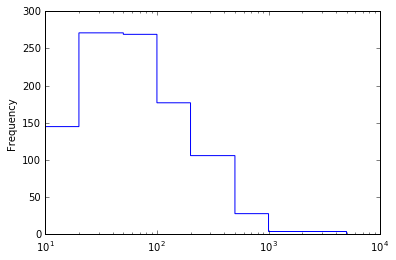

In [5]:
combo_df['text_length'].sample(1000).plot.hist(histtype ='step', bins = [0, 20, 50, 100, 200, 500, 1000, 5000]);
plt.xscale('log')

In [6]:
combo_df = combo_df.query('text_length > 40')
combo_df.shape

(1710957, 7)

#### Save / load combined months

In [3]:
combo_df = pd.read_csv('combined_months.tsv',
                       sep ='\t', compression = 'gzip', encoding ='utf-8')

C:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
combo_df = combo_df.query('text_length > 40 and text_length < 500')
combo_df.shape

(1638077, 7)

#### Parse into sentences

In [7]:
%%time
sentences_df = (pd.DataFrame(combo_df.text.apply(sent_tokenize).tolist(), index=combo_df.index)
                  .stack() )
sentences_df = (sentences_df.reset_index()
                  .set_index('level_0')
                  .rename(columns={0:'sentences'})
                  .drop('level'))
sentences_df['sentences'] = sentences_df['sentences'].str.replace('\r|\n', ' ')

Wall time: 5min 57s


In [13]:
combo_df = combo_df.join(sentences_df)[['user', 'flair', 'source', 'sentences', 'timestamp']]
combo_df.shape

,user,flair,source,sentences,timestamp
1,Mikka79,NaN,submission,If KD didn't go to the Warriors where do you t...,1.512230e+09
1,Mikka79,NaN,submission,Stayed in Oklahoma City?,1.512230e+09


Save / load

In [95]:
combo_df = pd.read_csv('combined_months_sentences.tsv.gz',
                       sep = '\t', compression ='gzip', encoding='utf-8')
combo_df = combo_df[combo_df.sentences.str.len() > 10]

C:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### NER

In [ ]:
from nltk import word_tokenize, sent_tokenize, pos_tag, ne_chunk
import nltk
from sner import Ner
tagger = Ner(host='localhost',port=9199)
# need to start the Java server:
# cd Lib\site-packages\sner\stanford-ner-2018-02-27
# java -Djava.ext.dirs=./lib -cp stanford-ner.jar edu.stanford.nlp.ie.NERServer -port 9199 -loadClassifier ./classifiers/english.all.3class.distsim.crf.ser.gz  -tokenizerFactory edu.stanford.nlp.process.WhitespaceTokenizer -tokenizerOptions tokenizeNLs=false

In [97]:
%%time
sner_entities = lambda text: [token for token, part in tagger.get_entities(text ) if part in {'PERSON', 'ORGANIZATION', 'LOCATION'}]
combo_df['named_entities'] = combo_df['sentences'].apply(lambda doc: sner_entities(doc))

Wall time: 2h 16min 42s


Save / load

In [98]:
combo_df.to_csv('combined_months_ner.tsv.gz', sep ='\t', compression='gzip',
               index=False, encoding = 'utf-8')

In [99]:
%%time
combo_df = pd.read_csv('combined_months_ner.tsv.gz', sep='\t', compression='gzip',
                      encoding ='utf-8')

<string>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 11.1 s


In [100]:
%%time
# ~ 1 min
combo_df['named_entities'] = combo_df['named_entities'].apply(literal_eval)
combo_df = combo_df[combo_df['named_entities'].str.len() > 0]
combo_df = combo_df[combo_df['sentences'].str.len() > 15]
combo_df['named_entities'] = combo_df['named_entities'].apply(lambda entities: [entity.strip(punctuation) for entity in entities])
combo_df['named_entities'] = combo_df['named_entities'].apply(lambda entities: [entity.lower() for entity in entities])

Wall time: 57.8 s


In [101]:
combo_df.shape

(766138, 6)

### Clean named entities
#### Remove teams, replace acronyms, and filter down to two entities

In [154]:
teams = set('Atlanta Hawks Boston Celtics Brooklyn Nets Charlotte Bobcats' \
         'Chicago Bulls Cleveland Cavaliers cavs Dallas Mavericks mavs Denver Nuggets ' \
'Detroit Pistons Golden State Warriors Houston Rockets Indiana'\
         'Pacers Los Angeles LA Clippers LA Lakers Memphis Grizzlies Miami Heat '\
'Milwaukee Bucks Minnesota Timberwolves NBA New Orleans Hornets New York Knicks '\
'Oklahoma City Thunder okc Orlando Magic Philadelphia Sixers 76ers Phoenix'\
         'Suns Portland Trail Blazers Sacramento Kings'\
'San Antonio Spurs Toronto Raptors Utah Jazz Washington Wizards wiz'.lower().split())

In [155]:
combo_df['named_entities'] = combo_df['named_entities'].apply(lambda entities: [entity for entity in entities if entity not in teams])
combo_df = combo_df[combo_df['named_entities'].str.len() > 0]

(450420, 12)

### Below is untested, but should work; might not be worth time

In [216]:
initials_dict = {'lbj':'lebron', 'kd':'durant', 'lma':'lamarcus', 'tt':'tristan'}

In [ ]:
combo_df['named_entities'] = combo_df['named_entities'].apply(lambda entities: [initials_dict.get(entity, entity) for entity in entities])

## Below deduping is not tested; it potentially could impact fuzzy matching

In [ ]:
combo_df['named_entities'] = combo_df['named_entities'].apply(lambda row: list(set(row)))
combo_df = combo_df[combo_df['named_entities'].str.len() <3]
combo_df.shape

### Sentiment scoring

In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [203]:
stat_words = ['steal', 'steals', 'block', 'blocked', 'blocks', 'slam', 'charges', 'rejection', 'free', 'assists']
neutral_words = ['offense', 'offensive', 'offensively', 'defense', 'defensive', 'defensively', 'defender',
                 'injury', 'injured', 'strain', 'questionable', 'isolation',
                 'shoot', 'doubtful', 'play', 'plays', 'crazy', 'turnover', 'turnovers',
                 'seriously', 'jj']
bad_words = ['foul', 'vicious', 'ridiculous', 'motherfucking', 'mediocre', 'no']
great_words = ['goat', 'nasty', 'prime', 'underrated', 'highlight', 'hilight']
sid.lexicon.update({word:0.1 for word in stat_words})
sid.lexicon.update({word:0 for word in neutral_words})
sid.lexicon.update({word:-0.5 for word in bad_words})
sid.lexicon.update({word:1 for word in great_words})

In [150]:
%%time
intermediate_df = combo_df['sentences'].apply(lambda sentence: sid.polarity_scores(sentence) )
sentiment_df = pd.DataFrame.from_dict(intermediate_df.tolist())

Wall time: 2min 31s


In [153]:
combo_df = combo_df.join(sentiment_df)
combo_df.head()

,user,flair,source,sentences,timestamp,named_entities,str_entities,fuzzy_name,compound,neg,neu,pos
0,EmNightShyamalan,[LAL] Julius Randle,submission,Is there a mediocre NBA player who has a deceptively impressive highlight reel?,1.512227e+09,[nba],nba,unclear,0.6908,0.0,0.612,0.388
1,Mithridates12,[CLE] LeBron James,submission,Do you think the NBA will at some change the rule in favor of the defense?.,1.512212e+09,[nba],nba,unclear,0.4019,0.0,0.847,0.153
2,Nickelas,Mavericks,submission,"Random Idea: Why hasn't the NBA thought to do an annual ""ABA Night""?.",1.512209e+09,[nba],nba,unclear,0.0000,0.0,1.000,0.000
3,Nickelas,Mavericks,submission,"The NBA could pick a Sunday and have a back-to-back nationally televised night: a combination of the Spurs, Pacers, Nets, and Nuggets.",1.512209e+09,[nba],nba,unclear,0.0000,0.0,1.000,0.000
4,jallain,[BOS] Paul Pierce,submission,"According to NBA.com, the Atlanta Hawks are currently the only team in the NBA averaging more passes received per game (327.7) than passes made (327.4).",1.512209e+09,[nba],nba,unclear,0.0000,0.0,1.000,0.000


#### Make sure positive and negative sentiment are directional

In [90]:
combo_df.query('neg< -0.1 and pos > 0.1')[['sentences', 'pos', 'neg']].tail(200).head(10).values

array([['And Rose was the worst of those 3.', 0.369, -0.6249],
       [ 'I think this is a little unfair of Windhorst to bring up a private conversation he supposedly had with Lebron years ago though.',
        0.129, -0.4228],
       [ 'He is admitting that Rose deserved it in 2011 and was upset with himself that he let someone outplay him.',
        0.12, -0.3818],
       [ 'Windhorst talking out of his ass (as he usually does on LeBron) and everyone on here taking it as if LeBron said it himself',
        0.132, -0.5423],
       [ 'I always thought it was the second Nash MVP that people had a problem with.',
        0.184, -0.4019],
       [ "Not undermining Rose's achievements, but without Dwight that team is awful.",
        0.39, -0.6956],
       [ 'I think the 2 years he concedes are obviously Curry in 2016, Steph broke basketball that year, and KD in 2014.',
        0.135, -0.4215],
       ['Probably the weakest since Nash actually.', 0.39799999999999996,
        -0.5106],
    

In [156]:
combo_df.to_csv('combined_months_ner_sentiment.tsv.gz', compression = 'gzip',
               index=False, encoding = 'utf-8')

In [245]:
combo_df = pd.read_csv('combined_months_ner_sentiment.tsv.gz', compression = 'gzip',
                       encoding = 'utf-8')
combo_df['named_entities'] = combo_df['named_entities'].apply(literal_eval)

In [247]:
combo_df.shape

(450420, 12)

## Join player demographics to performance

In [187]:
race_per_df = pd.read_csv('players2018.tsv', sep ='\t', encoding = 'utf-8')
race_per_df['Player'] = race_per_df['Player'].str.lower()

In [188]:
height_dict = {'{}-Jun'.format(x):x + 72 for x in range(1,12)}
height_dict.update({'{}-May'.format(x):x + 60 for x in range(5,12)})
height_dict.update({'{}-Jul'.format(x):x + 84 for x in range(1,12)})
height_dict.update({'Jul-00':84, 'Jun-00':72})

In [189]:
race_per_df['inches'] = race_per_df['Ht'].apply(lambda ht: height_dict[ht])

In [190]:
performance_df = (pd.read_html('https://www.basketball-reference.com/leagues/NBA_2018_advanced.html')[0]
                    .drop_duplicates('Player', keep = 'first'))
performance_df['Player'] = performance_df['Player'].str.lower()

In [191]:
race_per_df = race_per_df.merge(performance_df, on = 'Player')
race_per_df.head(2)

,Player,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,experience,Race,...,,OWS,DWS,WS,WS/48,.1,OBPM,DBPM,BPM,VORP
0,alex abrines,2017,2018,G-F,6-Jun,190,1-Aug-93,NaN,1,W,...,NaN,1.3,1.0,2.2,.094,NaN,-0.5,-1.7,-2.2,-0.1
1,quincy acy,2013,2018,F,7-Jun,240,6-Oct-90,Baylor University,5,B,...,NaN,-0.1,1.1,1.0,.036,NaN,-2.0,-0.2,-2.2,-0.1


In [113]:
unique_names = set(race_per_df.Player.unique())
def find_player( potential_name):
    names = fuzzy_process.extractBests(potential_name, unique_names, score_cutoff=80)
    
    if (len(names) > 1 and names[0][1] == names[1][1]) or len(names) == 0:
    # no clear match, return 'unclear match'
        return 'unclear'
    # only one similar, or clear top similar
    return names[0][0]

In [114]:
%%time
top_entities['fuzzy_name'] = top_entities['str_entities'].apply(find_player)

Wall time: 2min 41s


In [244]:
combo_df = combo_df.merge(top_entities, on = 'str_entities')
combo_df.head()

,user,flair,source,sentences,timestamp,named_entities,str_entities,fuzzy_name_x,compound,neg,neu,pos,fuzzy_name_y
0,TheAnonymousUsername,[CHI] Derrick Rose,submission,"Since Role Player is argued about, for now let’s just consider it a player who hasn’t been a legitimate ASG candidate for the past ~4 years.",1.512226e+09,[asg],asg,unclear,-0.3612,0.098,0.902,0.000,unclear
1,rosesarewet,Spurs,submission,LeBron doesn't think facing teammates in ASG would hurt Cavs locker room.,1.513476e+09,[asg],asg,unclear,-0.5267,0.236,0.764,0.000,unclear
2,Lebron2Portland2018,Trail Blazers,submission,"He has so many legitimate accolades, but when you include ASG MVP it looks like a joke Edit: if you don’t believe me that people do this, here’s just one example I saw today: https://np.reddit.com/r/nba/comments/7knw8v/oc_kobe_824_breakdown/",1.513659e+09,[asg],asg,unclear,0.7227,0.000,0.837,0.163,unclear
3,maybeAriadne,[GSW] Kevon Looney,comment,It's probably not gonna happen but I so want them to be teammates in the ASG,1.512175e+09,[asg],asg,unclear,0.2759,0.000,0.869,0.131,unclear
4,CoilConductor,Knicks,comment,"DJ has really benefited from cp3 lobs for exposure, I don't think he makes the ASG at all.",1.512386e+09,[asg],asg,unclear,0.0000,0.000,1.000,0.000,unclear


#### Save / load

In [205]:
combo_df = pd.read_csv('combined_months_ner_sentiment.tsv.gz', compression = 'gzip',
                       encoding = 'utf-8')
combo_df['named_entities'] = combo_df['named_entities'].apply(literal_eval)

In [224]:
combo_df.query('fuzzy_name == "unclear"')['str_entities'].value_counts().head(120).tail(40)#sample(40)[['sentences', 'named_entities']]

asg              488
d'antoni         487
gilbert          485
iverson          482
teague           479
harris           474
bill             473
larry            473
steve nash       462
payton           453
bill russell     443
ty lue           442
barkley          437
europe           435
luke             435
joel             432
spo              431
bagley           430
collins          425
jerry west       417
adam silver      417
ray              409
anderson         407
usa              406
nhl              405
parker           395
turner           393
morey            387
pau              383
phil             381
lin              380
tj               373
reggie miller    371
niko             367
pippen           365
timmy            363
dan gilbert      363
johnson          355
casey            354
joe              353
Name: str_entities, dtype: int64

## Aggregating sentiment and joining to performance

In [207]:
match_df = combo_df.query('fuzzy_name != "unclear"')
match_df.shape

(242478, 12)

In [170]:
mean_sentiment_df = (match_df.groupby('fuzzy_name')
                          .agg({'neg':['mean', 'std', 'count'],
                                'pos':['mean', 'std'],
                                'compound':['mean', 'std']})
                          .query('fuzzy_name != "marcus smart" and fuzzy_name != "kevin love"')
                    )
mean_sentiment_df.columns = ['pos_mean', 'pos_std', 'comment_count', 'neg_mean', 'neg_std', 'compound_mean', 'compound_std']
mean_sentiment_df['compound_se'] = mean_sentiment_df['compound_std'] / np.sqrt(mean_sentiment_df['comment_count'])

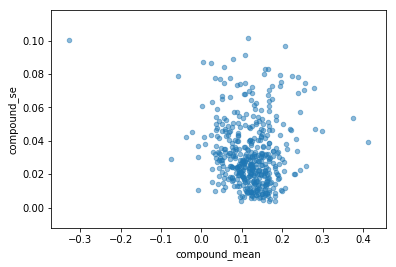

In [176]:
mean_sentiment_df.plot.scatter('compound_mean', 'compound_se', alpha = 0.5)

In [173]:
mean_sentiment_df.sort_values('compound_mean').head(10)

,pos_mean,pos_std,comment_count,neg_mean,neg_std,compound_mean,compound_std,compound_se
fuzzy_name,,,,,,,,
sterling brown,0.214261,0.162251,23,0.082000,0.106548,-0.327857,0.480741,0.100241
jeff teague,0.127697,0.180871,201,0.077831,0.132782,-0.076183,0.415457,0.029304
xavier silas,0.119615,0.158570,26,0.086615,0.120305,-0.058550,0.400879,0.078619
damian jones,0.061373,0.115022,59,0.057441,0.113745,-0.037605,0.324124,0.042197
joffrey lauvergne,0.113243,0.169682,74,0.102514,0.146767,-0.022307,0.392079,0.045578
zaza pachulia,0.102571,0.141526,1602,0.098476,0.129838,-0.007752,0.419069,0.010470
mike james,0.107238,0.148587,122,0.110107,0.144887,-0.007736,0.408877,0.037018
salah mejri,0.114202,0.145907,233,0.121489,0.141489,-0.007595,0.461216,0.030215
andrew harrison,0.065893,0.121128,28,0.084321,0.098709,0.001789,0.321170,0.060696


In [174]:
mean_sentiment_df.sort_values('compound_mean').tail(10)

,pos_mean,pos_std,comment_count,neg_mean,neg_std,compound_mean,compound_std,compound_se
fuzzy_name,,,,,,,,
trey mckinney-jones,0.020148,0.055739,27,0.144037,0.155448,0.244681,0.297973,0.057345
j.j. barea,0.072014,0.117093,278,0.213371,0.169937,0.245092,0.374548,0.022464
lorenzo brown,0.032407,0.072510,27,0.152593,0.132312,0.253007,0.365935,0.070424
e'twaun moore,0.020143,0.063806,21,0.141762,0.150225,0.256952,0.340815,0.074372
luke kennard,0.039116,0.089353,241,0.185108,0.183586,0.259263,0.384827,0.024789
sam dekker,0.025308,0.056580,26,0.184808,0.175681,0.278258,0.366114,0.071801
jerami grant,0.073466,0.107215,58,0.258328,0.137728,0.280343,0.360298,0.047309
derrick favors,0.045729,0.095379,48,0.268833,0.137151,0.299025,0.319007,0.046045
jerian grant,0.038946,0.096214,37,0.251784,0.137831,0.376665,0.325332,0.053484


### Regression model

In [177]:
mean_sentiment_df = mean_sentiment_df.query('compound_se < 0.05')

In [192]:
join_df = (mean_sentiment_df.reset_index()
                         .merge(race_per_df, left_on = 'fuzzy_name', right_on = 'Player'))
for col in {'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'PER', 'WS/48', 'Age', 'Wt'}:
    join_df[col] = pd.to_numeric(join_df[col])

In [193]:
join_df.groupby('Race').mean()

,pos_mean,pos_std,comment_count,neg_mean,neg_std,compound_mean,compound_std,compound_se,From,To,...,PER,TRB%,AST%,STL%,BLK%,TOV%,USG%,,WS/48,.1
Race,,,,,,,,,,,,,,,,,,,,,
A,0.063500,0.113135,139.000000,0.107656,0.136413,0.077586,0.383483,0.036375,2014.500000,2018.0,...,8.900000,5.000000,14.600000,0.400000,4.800000,18.900000,24.050000,NaN,-0.008500,NaN
B,0.059108,0.108608,632.617978,0.121676,0.145542,0.121036,0.376899,0.024812,2012.599251,2018.0,...,13.762547,9.598127,14.145693,1.643820,1.676030,12.769288,19.523221,NaN,0.083397,NaN
M,0.061486,0.111129,2336.384615,0.126233,0.148901,0.133067,0.391770,0.018048,2013.153846,2018.0,...,16.892308,9.576923,21.653846,1.846154,1.253846,13.607692,22.600000,NaN,0.110231,NaN
R,0.088155,0.127592,200.000000,0.115960,0.139572,0.043657,0.414134,0.029309,2017.000000,2018.0,...,11.450000,13.050000,7.150000,1.450000,4.900000,18.000000,14.950000,NaN,0.080500,NaN
W,0.059271,0.109656,457.397590,0.121121,0.146479,0.119999,0.377995,0.027338,2013.156627,2018.0,...,14.300000,11.810843,11.436145,1.209639,1.819277,13.551807,18.063855,NaN,0.104602,NaN


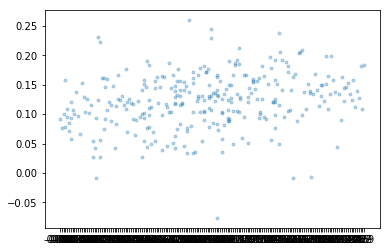

In [154]:
plt.plot(join_df['WS/48'].values, join_df['compound_mean'].values, '.',alpha= 0.3);

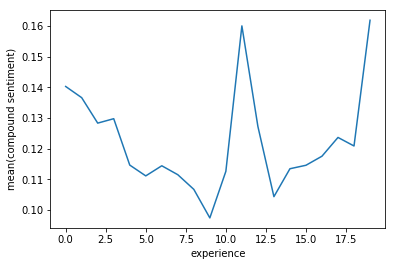

In [132]:
(join_df.groupby('experience')
        .agg({'compound_mean':['mean', 'size']})
        .iloc[:,0]
        .plot())#[['compound_mean']])
plt.ylabel('mean(compound sentiment)');

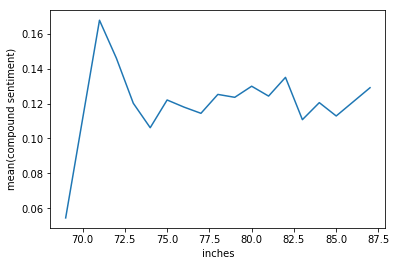

In [133]:
(join_df.groupby('inches')
        .agg({'compound_mean':['mean', 'size']})
        .iloc[:,0]
        .plot())#[['compound_mean']])
plt.ylabel('mean(compound sentiment)');

In [195]:
model_df = pd.concat([join_df, pd.get_dummies(join_df['Race'])], axis = 1)
model_df['rookie'] = (model_df['experience'] == 0).astype(int)
model_df['whippersnapper'] = ((model_df['experience'] > 0) & model_df['experience'] < 4).astype(int)
model_df['geezer'] = (model_df['experience'] > 9).astype(int)
model_df['tall'] = (model_df['inches'] > 82).astype(int)
model_df['short'] = (model_df['inches'] < 72).astype(int)

In [196]:
import statsmodels.api as sm

# Note the difference in argument order
model = sm.OLS( model_df['compound_mean'].values,
               model_df[['WS/48', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
                         'M', 'W', 'inches', 'Wt' ,'rookie', 'whippersnapper', 'geezer', 'tall', 'short']]).fit()

In [197]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     2.984
Date:                Sat, 19 May 2018   Prob (F-statistic):           0.000164
Time:                        18:15:43   Log-Likelihood:                 581.54
No. Observations:                 367   AIC:                            -1131.
Df Residuals:                     351   BIC:                            -1069.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
WS/48              0.1657      0.046      3.600      0.000       0.075       0.256
TRB%               0.0012      0.001      1.389      0.166      -0.001       0.003
AST%              -0.0005      0.000     -0.996      0.320      -0.001       0.000
STL%              -0.0014      0.003     -0.430      0.667      -0.008       0.005
BLK%               0.0015      0.002      0.615      0.539      -0.003       0.006
TOV%              -0.0003      0.001     -0.543      0.588      -0.002       0.001
USG%               0.0009      0.001      1.523      0.129      -0.000       0.002
M                  0.0074      0.015      0.504      0.615      -0.021       0.036
W                  0.0019      0.007      0.256      0.798      -0.013       0.016
inches             0.0016      0.002      0.900      0.369      -0.002       0.005
Wt                -0.0004      0.000     -2.256      0.025      -0.001    -5.5e-05
rookie             0.0257      0.008      3.162      0.002       0.010       0.042
whippersnapper     0.0546      0.118      0.463      0.644      -0.177       0.286
geezer             0.0121      0.007      1.657      0.098      -0.002       0.026
tall              -0.0239      0.010     -2.463      0.014      -0.043      -0.005
short             -0.0052      0.028     -0.185      0.854      -0.060       0.050
==============================================================================
Omnibus:                       44.042   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.355
Skew:                           0.349   Prob(JB):                     1.55e-45
Kurtosis:                       6.607   Cond. No.                     1.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""